https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

In [ ]:
import re
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from bertopic import BERTopic
import demoji
import spacy
import unidecode
from umap import UMAP
from bertopic import BERTopic
import gensim
import gensim.corpora as corpora
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from gensim.models.coherencemodel import CoherenceModel

/home/carg/anaconda3/envs/bertopic/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/carg/anaconda3/envs/bertopic/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/carg/anaconda3/envs/bertopic/lib/python3.8/site-packages/umap/dist

In [ ]:
import torch


In [ ]:
if torch.cuda.is_available():
    print("Using GPU.")
else:
    print("Using CPU.")


Using GPU.


In [ ]:
nlp = spacy.load("es_core_news_sm")

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /home/carg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/carg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
spanish_stop_words = nltk.corpus.stopwords.words('spanish')

In [ ]:
df = pd.read_csv("/home/carg/Escritorio/Bert_1000/balanceo_1000.csv") 

In [ ]:
df.head(1)

,topic,text,date_query
0,politica,corte internacional justicia haya colombia tod...,2022-08-30T18:01:55.226Z


In [ ]:
#eliminacion de emojis
def clean_text(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'#[A-Za-z0-9]*', ' ', x)
  x = re.sub(r'https*://.*', ' ', x)
  

  x = re.sub(r'@[A-Za-z0-9]+', ' ', x)
  
  # remove emojis
  demoji.download_codes()
  x = demoji.replace(x, '')

  # remove accents
  x = unidecode.unidecode(x)
  
  tokens = word_tokenize(x)
  x = ' '.join([w for w in tokens if not w.lower() in stop_words])
  x = re.sub(r'[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~“…”’'), ' ', x)
  x = re.sub(r'\d+', ' ', x)
  x = re.sub(r'\n+', ' ', x)
  x = re.sub(r'\s{2,}', ' ', x)
  return x

In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


In [ ]:
df['clean_text'] = df.text.apply(clean_text)
df['lemmatized_text'] = df['clean_text'].apply(lemmatize_text)

In [ ]:
df.head()

,topic,text,date_query,clean_text,lemmatized_text
0,politica,corte internacional justicia haya colombia tod...,2022-08-30T18:01:55.226Z,corte internacional justicia colombia todavia ...,corte internacional justicia colombia todavia ...
1,politica,domingo bogotanos vieron dos situaciones disti...,2022-01-17T19:04:23.376Z,domingo bogotanos vieron dos situaciones disti...,domingo bogotano ver dos situación distinto re...
2,politica,comicios año entra hechos escoger autoridades ...,2022-10-29T15:19:18.159Z,comicios ano entra hechos escoger autoridades ...,comicio ano entrar hecho escoger autoridad ter...
3,politica,llamada puerta giratoria permite congresistas ...,2022-12-13T19:33:30.008Z,llamada puerta giratoria permite congresistas ...,llamado puerta giratorio permitir congresista ...
4,politica,después roces ‘tostao’ grupo colombiano choqui...,2020-04-21T16:24:05.033Z,despues roces 'tostao ' grupo colombiano choqu...,despues roce ' tostao ' grupo colombiano choq...


In [ ]:
df.to_csv("limpios.csv")

Generacion Labels

In [ ]:
unique_labels = df['topic'].unique()
label_mapping = {label: index for index, label in enumerate(unique_labels)}
df['Labels'] = df['topic'].map(label_mapping)

In [ ]:
class_counts = df['Labels'].value_counts()
print(class_counts)


Labels
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
Name: count, dtype: int64


In [ ]:
df.head(2)

,topic,text,date_query,clean_text,lemmatized_text,Labels
0,politica,corte internacional justicia haya colombia tod...,2022-08-30T18:01:55.226Z,corte internacional justicia colombia todavia ...,corte internacional justicia colombia todavia ...,0
1,politica,domingo bogotanos vieron dos situaciones disti...,2022-01-17T19:04:23.376Z,domingo bogotanos vieron dos situaciones disti...,domingo bogotano ver dos situación distinto re...,0


**BERT**

Division entrenamiento-prueba

In [ ]:
num_classes = len(df["Labels"].value_counts())

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_text'], y, test_size=0.2)

In [ ]:
# for Colab users: !pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


2023-05-21 13:37:26.521628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-21 13:37:26.522158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-21 13:37:26.522256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-21 13:37:26.522705: I tensorflow/core/

In [ ]:

def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Questa collezione di Haiku è una porta aperta sulla cultura giapponese."]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 1.08269542e-01, -9.16301310e-02, -3.19652945e-01,
        -1.70695502e-02,  3.34133416e-01,  2.00266361e-01,
        -2.46936113e-01, -5.43310404e-01, -3.56957167e-01,
        -2.97796339e-01, -2.08980888e-01,  1.42026037e-01,
         2.72505525e-02, -4.33980584e-01, -5.73599875e-01,
        -8.82729590e-01,  2.37144023e-01, -1.87128350e-01,
        -2.56524473e-01, -2.46629849e-01,  6.32454336e-01,
         1.21353820e-01, -3.95605922e-01,  1.58425838e-01,
        -6.60167709e-02, -1.00859594e+00,  3.03424984e-01,
         2.40526702e-02, -9.84720886e-02, -6.36505127e-01,
         1.15401953e-01, -7.62528777e-01, -5.43886602e-01,
        -4.67391849e-01, -6.24043107e-01,  2.63593137e-01,
        -4.41221416e-01,  6.62040040e-02, -3.88787836e-01,
         1.61615517e-02,  1.15522951e-01, -4.35086370e-01,
        -5.12637436e-01,  2.74717361e-01, -3.44001025e-01,
        -1.88090250e-01,  1.52754821e-02, -3.23565453e-01,
      

In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
import tensorflow as tf


In [ ]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

2023-05-21 13:37:45.641159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-21 13:37:45.655963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-05-21 13:37:45.747102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-21 1

In [ ]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20


2023-05-21 13:38:15.873672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/lambda_8/PartitionedCall_grad/lambda_8/PartitionedCall' with dtype float and shape [?,768]
	 [[{{node gradients/lambda_8/PartitionedCall_grad/lambda_8/PartitionedCall}}]]
2023-05-21 13:38:15.873740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/lambda_8/PartitionedCall_grad/lambda_8/PartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/lambda_8/PartitionedCall_grad/lambda_8/PartitionedCall_1}}]]
2023-05-21 13:38:15.873773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Ex

150/150 [==============================] - 840s 6s/step - loss: 1.2502 - accuracy: 0.6044 - balanced_recall: 0.1618 - balanced_precision: 0.3874 - balanced_f1_score: 0.2231 - val_loss: 0.8526 - val_accuracy: 0.7900 - val_balanced_recall: 0.4650 - val_balanced_precision: 0.8411 - val_balanced_f1_score: 0.5957
Epoch 2/20
150/150 [==============================] - 835s 6s/step - loss: 0.7430 - accuracy: 0.8002 - balanced_recall: 0.5857 - balanced_precision: 0.8767 - balanced_f1_score: 0.6985 - val_loss: 0.6450 - val_accuracy: 0.8100 - val_balanced_recall: 0.6628 - val_balanced_precision: 0.8850 - val_balanced_f1_score: 0.7559
Epoch 3/20
150/150 [==============================] - 819s 5s/step - loss: 0.6045 - accuracy: 0.8233 - balanced_recall: 0.7022 - balanced_precision: 0.8873 - balanced_f1_score: 0.7820 - val_loss: 0.5666 - val_accuracy: 0.8275 - val_balanced_recall: 0.7212 - val_balanced_precision: 0.8798 - val_balanced_f1_score: 0.7909
Epoch 4/20
150/150 [============================

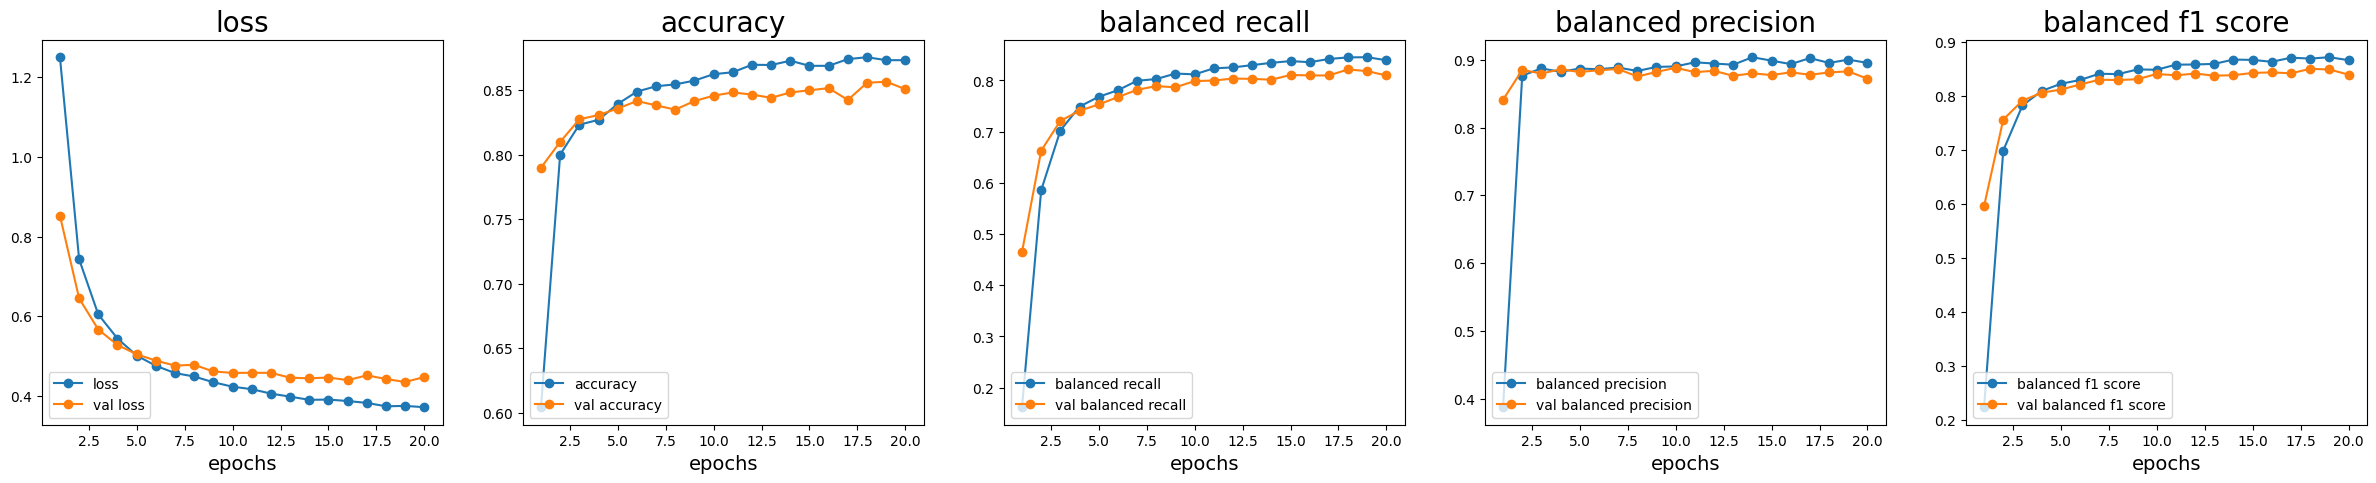

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [ ]:
results = model.evaluate(x_test, y_test)

# Obtener las métricas específicas
precision = results[METRICS.index(balanced_precision)]
recall = results[METRICS.index(balanced_recall)]
f1_score = results[METRICS.index(balanced_f1_score)]

# Imprimir los resultados
print("Precisión:", precision)
print("Recall:", recall)
print("Puntuación F1:", f1_score)


38/38 [==============================] - 161s 4s/step - loss: 0.4476 - accuracy: 0.8508 - balanced_recall: 0.8097 - balanced_precision: 0.8721 - balanced_f1_score: 0.8392
Precisión: 0.8097167015075684
Recall: 0.8508333563804626
Puntuación F1: 0.8721074461936951


prueba

In [ ]:
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['lemmatized_text'], y, test_size=0.2)

# Convertir x_test en una lista
x_test = x_test.tolist()

# Crear un DataFrame con los datos de prueba
test_data = pd.DataFrame({'Text': x_test, 'Labels': y_test.argmax(axis=1)})

In [ ]:
# Guardar los datos en un archivo CSV
test_data.to_csv('datos_prueba.csv', index=False)

metricas

In [ ]:
reviews = [
    "Questa collezione di Haiku è una porta aperta sulla cultura giapponese.",
    "Questo libro descrive l'emancipazione femminile nella cultura patriarcale.",
    "Questo trattato di economia moderna è il vademecum di qualsiasi appassionato di mercati finanziari."
]

In [ ]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(reviews)

1/1 [==============================] - 0s 307ms/step


[5, 3, 1]

In [ ]:
test_set = pd.read_csv('/home/carg/Escritorio/Bert_1000/datos_prueba.csv')

test_set.head()

,Text,Labels
0,nino comenzar salir vacación mitad ano activid...,5
1,mery gutierrez asumirio cartera tecnologia inf...,4
2,uala fintech origen argentino ofrecer ecosiste...,1
3,si usted persona poner nervioso entrevista tra...,4
4,frase semanael coraje historia amor desconocid...,5


In [ ]:
from sklearn.metrics import classification_report


y_pred = predict_class(test_set["Text"])
print(classification_report(test_set["Labels"], y_pred))

38/38 [==============================] - 167s 4s/step
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       214
           1       0.85      0.87      0.86       203
           2       0.98      0.93      0.95       181
           3       0.82      0.83      0.83       202
           4       0.93      0.88      0.90       206
           5       0.79      0.82      0.81       194

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200

